# Distributed Deep Learning with Apache Spark and Keras

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

In [1]:
!(date +%d\ %B\ %G)

23 October 2016


This presentation will give the reader an introduction to the topic of distributed deep learning (DDL) and to the issues which need to be taken into consideration when applying this technique. We will also introduce a DDL framework based on a **fast and general engine for large-scale data processing** called [Apache Spark](https://spark.apache.org/) and the **neural network library** [Keras](https://keras.io). 

The project was initially initiated by the CMS experiment. CMS is exploring the possibility to use a deep learning model for the high level trigger in order to be able to handle the data rates for LHC run 3 and up. Furthermore, they would like to be able to train their models faster using distributed algorithms which allows them to tune their models with an increased frequency. An other requirement was those models should be trained on their complete dataset, which is in the order of a TB.

## Contents

- [Introduction and problem statement](#Distributed-Deep-Learning,-an-introduction.)
  - [Model parallelism](#Model-parallelism)
  - [Data parallelism](#Data-parallelism)
- [Usage](#Distributed-Keras:-a-practicle-example)
- [Conclusion](#Conclusion)
- [Scaling](#Scaling)
- [Experimental observations](#Experimental-observations)
- [Summary](#Summary)
- [Future work](#Future-work)
- [Acknowledgments](#Acknowledgments)

## Distributed Deep Learning, an introduction.

Unsupervised feature learning and deep learning has shown that being able to train large models can dramatically improve performance. However, consider the problem of training a deep network with billions of parameters. How do we achieve this without waiting for days, or even weeks, and thus leaving more time to tune the model? Dean et al. [[1]](https://papers.nips.cc/paper/4687-large-scale-distributed-deep-networks.pdf) proposed an training paradigm which allows us to train a model on multiple physical machines. The authors describe two methods to achieve this, i.e., **data parallelism** and **model parallelism**<sup>1</sup>.

### Model parallelism<sup><span style="font-size: 0.75em">2</span></sup>

In model parallelism a *single* model is distributed over multiple machines. The performance benefits of distributing a deep network across multiple machines depends mainly on the structure and of the model. Models with a large number of parameters typically benefit from access to more CPUs and memory, up to the point where communication costs, i.e., propagation of the weight updates and synchronization mechanisms, dominate [[1]](https://papers.nips.cc/paper/4687-large-scale-distributed-deep-networks.pdf).

<img src="../resources/model_parallelism.png" alt="Model Parallelism" width="300px" />

### Data parallelism

As stated in the introduction, in order to train a large network in a reasonable amount of time, we need to parallize the optimization process (which is the learning of the model). In this settings, we take *several* model replicas, and distribute them over multiple machines. Of course, it would also be possible to combine this with the model parallelism approach. However, for the sake of simplicity, let us assume that a model (or several models) can be contained on a single machine. In order to parallelize the training, and to improve the usage of the resources of the cluster, we distribute the models over several machines.

In order to build a distributed learning scheme using data parallelism, you would in the most simple case need at least 1 **parameter server**. A parameter server is basically a thread (or a collection of threads) which aggregate the incoming gradient updates of the workers into a so-called center variable, which acts as a *global consensus* variable. Finally, the weights which are stored in the center variable will eventually be used by the produced model.

<img src="../resources/data_parallelism.png" alt="Data Parallelism" width="400px" />

There are two general approaches towards solving data parallelism. The most straightforward is a **synchronous** method. In short, a synchronous data parallel method will wait for all workers to finish the current mini-batch or stochastic sample before continuing to the next iteration. Synchronous methods have the advantage that all workers will use the most recent center variable, i.e., a worker knows that all other workers will use the same center variable. However, the main disadvantage of this method is the synchronization itself. A synchronous method will never be truly synchronous. This is due to the many, and possibly different, machines. Furthermore, every machine could have a different workload, which would influence the training speed of a worker. As a result, synchronous methods need additional waiting mechanisms to synchronize all workers. These locking mechanisms will make sure that that all workers compute the next gradient based on the same center variable. However, locking mechanisms induce a significant wait which will significantly influence the training speed. For example, imagine a cluster node with an unusual high load. This high load will, due to CPU sharing, cause the training procedure to slow down. Which in turn, will cause the other workers to wait for this single node. Of course, this is just a simple and possibly extreme example, but this example shows how a single worker could significantly influence the training time of all workers.

<img src="../resources/synchronous_method.png" alt="Data Parallelism" width="500px" />

A very simple, but radical "solution" for this synchronization problem is to not synchronize the workers :) Workers simply fetch the center variable and update the parameter server with the computed gradient whenever a worker is ready. This approach is called an **asynchronous** data parallel method. Asynchronous methods, compared to synchronous methods, will have a different set of problems. One of these is a so-called **stale gradient**. This a gradient based on an older version of the center variable while the current center variable is a center variable which has already been updated by other workers. One approach to solve this is to induce and exponential decay factor to the gradient updates. However, this would waste computational resources, but of course, one could just get the most recent weights from the parameter server and then start again. However, as we will show later, it is actually stale gradients (result of asynchrony) that induce *implicit momentum* to the learning process [[2]](https://arxiv.org/pdf/1606.04487v4.pdf).

<img src="../resources/asynchronous_method.png" alt="Data Parallelism" width="500px" />

At this point you probably ask the question: **why does this actually work?** A lot of people suggest this is due to the sparsity of the gradients. Intuitively, image having multiple workers processing different data (since every worker has its own dat partition), chances are the weights updates will be totally dissimilar since we are training a large network with a lot of tunable parameters. Furthermore, techniques such as dropout (if they are applied differently among the replicas) only increase the sparsity updates<sup>3</sup>.

### Formalization

We would also like to inform the reader that the general problem to be solved is the so-called **global consensus optimization** problem. A popular approach towards solving this is using the Alternating Direction Method of Multipliers (ADMM) [[3]](http://www.jmlr.org/proceedings/papers/v32/zhange14.pdf) [[4]](http://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf). However, since this is outside the scope of this notebook we will not review this in-depth. But, we would like to note that the *Elastic Averaging* methods [[5]](https://arxiv.org/pdf/1412.6651.pdf) by Zhang et al., which we included in *Distributed Keras* are based on ADMM.

<sub>**1:** Hybrids are possible as well.</sub>      
<sub>**2:** This is mainly used for the computation of the network outputs [[1]](https://papers.nips.cc/paper/4687-large-scale-distributed-deep-networks.pdf).</sub>           
<sub>**3:** A way to check the sparsity between 2 gradients is to put all the weights in to a 1 dimensional vector, and then compute the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

## Distributed Keras

Distributed Keras is a framework which uses Apache Spark and Keras. We chose for Spark because of the distributed environment. This allows us to preprocess the data in a distributed manner, and train our deep learning models on the same architecture, while still having the modeling simplicity of Keras.

### Architecture

Our architecture is very similar to the architecture discussed in [[1]](https://papers.nips.cc/paper/4687-large-scale-distributed-deep-networks.pdf). However, we employ Apache Spark for data parallel reading and handling larger than memory datasets. The parameter server will always be created in the **Spark Driver**. This **is the program which creates the Spark Context**. For example, if the Jupyter installation of this notebook is running on the Spark cluster, then a cluster node will host the parameter server. However, if you run a Python script, which connects to a remote Spark cluster, then your computer will run the Spark Driver, and as a result will run the parameter server. In that case, be sure your network connection is able to handle the load, else your computer will be the bottleneck in the learning process.

<img src="../resources/distkeras_architecture.png" alt="Model Parallelism" width="500px" />

### Implemention of costum distributed optimizer

In order to implement your own optimizer you need 2 classes. First, define your optimizer using the *Trainer* interface. We already supplied an *AsynchronousDistributedTrainer*, and an *SynchronousDistributedTrainer*. However, if you require an other procedure, please feel free to do so. Finally, you need a worker class. This class must have a *train* method with the required arguments, as specified by Apache Spark.

### Usage

In the following sections, we will give you an example how a complete workflow will look like. This includes setting up a Spark context, reading, preprocessing, and normalizing the data. Finally, we create a relatively simple model (feel free to adjust the parameters) with Keras and optimize it using the different distributed optimizers which are included by default.

#### Dataset

We are using the ATLAS Higgs dataset constructed for the Kaggle machine learning challenge. This dataset is quite limited, it contains only **250000** instances. 40% of which we will be using as a test set. For future experiments, it would be usefull to integrate well understood datasets such as CIFAR or MNIST to evaluate against other optimizers. However, it would be nice to have a "well understood" HEP (High Energy Physics) dataset for this task :) 

In [2]:
import numpy as np

import time

import requests

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from distkeras.distributed import *
from distkeras.utils import *

Using TensorFlow backend.


In [3]:
# Modify these variables according to your needs.
application_name = "Distributed Keras Notebook"
using_spark_2 = False
yarn = "p01001532067275.cern.ch:8088" # Address:port of ResourceManager
if not yarn:
    # Tell master to use local resources.
    master = "local[*]"
    num_cores = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    max_num_executors = 6
    num_cores = 4

In [4]:
# Check if YARN is specified.
if yarn:
    # Build the ResourceManager metrics URI.
    yarn_metrics_uri = "http://" + yarn + "/ws/v1/cluster/metrics"
    # Fetch the number of available nodes
    response = requests.get(yarn_metrics_uri)
    data = response.json()
    # Fetch the number of active nodes.
    num_active_nodes = int(data['clusterMetrics']['activeNodes'])
    # Assign the number of executors.
    num_executors = num_active_nodes
    if num_executors > max_num_executors:
        num_executors = max_num_executors

In [5]:
# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_cores

print("Number of desired executors: " + `num_executors`)
print("Number of desired cores / executor: " + `num_cores`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 6
Number of desired cores / executor: 4
Total number of workers: 24


In [6]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

#### Preparing a Spark Context

In order to read our (big) dataset into our Spark Cluster, we first need a Spark Context. However, since Spark 2.0 there are some changes in the initialization of a Spark Context. For example, SQLContext and HiveContext do not have to be initialized seperatly anymore, i.e., the initialization process is simplified.

In [7]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_cores`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [8]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferSchema='true').load("data/atlas_higgs.csv")

In [9]:
# Double-check the inferred schema, and get fetch a row to show how the dataset looks like.
raw_dataset.printSchema()

root
 |-- EventId: integer (nullable = true)
 |-- DER_mass_MMC: double (nullable = true)
 |-- DER_mass_transverse_met_lep: double (nullable = true)
 |-- DER_mass_vis: double (nullable = true)
 |-- DER_pt_h: double (nullable = true)
 |-- DER_deltaeta_jet_jet: double (nullable = true)
 |-- DER_mass_jet_jet: double (nullable = true)
 |-- DER_prodeta_jet_jet: double (nullable = true)
 |-- DER_deltar_tau_lep: double (nullable = true)
 |-- DER_pt_tot: double (nullable = true)
 |-- DER_sum_pt: double (nullable = true)
 |-- DER_pt_ratio_lep_tau: double (nullable = true)
 |-- DER_met_phi_centrality: double (nullable = true)
 |-- DER_lep_eta_centrality: double (nullable = true)
 |-- PRI_tau_pt: double (nullable = true)
 |-- PRI_tau_eta: double (nullable = true)
 |-- PRI_tau_phi: double (nullable = true)
 |-- PRI_lep_pt: double (nullable = true)
 |-- PRI_lep_eta: double (nullable = true)
 |-- PRI_lep_phi: double (nullable = true)
 |-- PRI_met: double (nullable = true)
 |-- PRI_met_phi: double (nu

#### Dataset preprocessing and normalization

Since Spark's MLlib has some nice features for some distributed dataprocessing, we follow MLlib (dataframe) API in order to ensure compatibility. What it basically boils down to, is that all the features (which can have different type) will be aggregated into a single column. More information on Spark MLlib (and other APIs) can be found here: [http://spark.apache.org/docs/latest/ml-guide.html](http://spark.apache.org/docs/latest/ml-guide.html)

In the following steps we will show you how to extract the desired columns from the dataset and prepare the for further processing.

In [10]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
features = raw_dataset.columns
features.remove('EventId')
features.remove('Weight')
features.remove('Label')
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset = vector_assembler.transform(raw_dataset)

# Show what happened after applying the vector assembler.
# Note: "features" column got appended to the end.
dataset.select("features").take(1)

[Row(features=DenseVector([138.47, 51.655, 97.827, 27.98, 0.91, 124.711, 2.666, 3.064, 41.928, 197.76, 1.582, 1.396, 0.2, 32.638, 1.017, 0.381, 51.626, 2.273, -2.414, 16.824, -0.277, 258.733, 2.0, 67.435, 2.15, 0.444, 46.062, 1.24, -2.475, 113.497]))]

In [11]:
# Apply feature normalization with standard scaling. This will transform a feature to have mean 0, and std 1.
# http://spark.apache.org/docs/latest/ml-features.html#standardscaler
standard_scaler = StandardScaler(inputCol="features", outputCol="features_normalized", withStd=True, withMean=True)
standard_scaler_model = standard_scaler.fit(dataset)
dataset = standard_scaler_model.transform(dataset)

In [12]:
# If we look at the dataset, the Label column consists of 2 entries, i.e., b (background), and s (signal).
# Our neural network will not be able to handle these characters, so instead, we convert it to an index so we can indicate that output neuron with index 0 is background, and 1 is signal.
# http://spark.apache.org/docs/latest/ml-features.html#stringindexer
label_indexer = StringIndexer(inputCol="Label", outputCol="label_index").fit(dataset)
dataset = label_indexer.transform(dataset)

# Show the result of the label transformation.
dataset.select("Label", "label_index").take(5)

[Row(Label=u's', label_index=1.0),
 Row(Label=u'b', label_index=0.0),
 Row(Label=u'b', label_index=0.0),
 Row(Label=u'b', label_index=0.0),
 Row(Label=u'b', label_index=0.0)]

In [13]:
# Define some properties of the neural network for later use.
nb_classes = 2 # Number of output classes (signal and background)
nb_features = len(features)

In [14]:
# We observe that Keras is not able to work with these indexes. What it actually expects is a vector with an identical size to the output layer. Our framework provides functionality to do this with ease. What it basically does, given an expected vector dimension, it prepares zero vector with the specified dimensionality, and will set the neuron with a specific label index to one.

# For example:
# 1. Assume we have a label index: 3
# 2. Output dimensionality: 5
# With these parameters, we obtain the following vector in the DataFrame column: [0,0,0,1,0]

label_vector_transformer = LabelVectorTransformer(output_dim=nb_classes, input_col="label_index", output_col="label")
dataset = label_vector_transformer.transform(dataset).toDF()
# Only select the columns we need (less data shuffling) while training.
dataset = dataset.select("features_normalized", "label_index", "label")

# Show the expected output vectors of the neural network.
dataset.select("label_index", "label").take(1)

[Row(label_index=1.0, label=DenseVector([0.0, 1.0]))]

In [15]:
# Shuffle the dataset.
dataset = shuffle(dataset)

# Note: we also support shuffling in the trainers by default.
# However, since this would require a shuffle for every training we will only do it once here.
# If you want, you can enable the training shuffling by specifying shuffle=True in the train() function.

In [16]:
# Finally, we create a trainingset and a testset.
(trainingSet, testSet) = dataset.randomSplit([0.7, 0.3])
trainingSet.cache()
testSet.cache()

DataFrame[features_normalized: vector, label_index: double, label: vector]

#### Model construction

We will now construct a relatively simple Keras model (without any modifications) which, hopefully, will be able to classify the dataset.

In [17]:
model = Sequential()
model.add(Dense(500, input_shape=(nb_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(500))
#model.add(Activation('relu'))
#model.add(Dropout(0.4))
#model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [18]:
# Summarize the model.
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 500)           15500       dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 500)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 500)           250500      dropout_1[0][0]                  
___________________________________________________________________________________________

##### Worker Optimizer and Loss

In order to evaluate the gradient on the model replicas, we have to specify an optimizer and a loss method. For this, we just follow the Keras API as defined in the documentation: [https://keras.io/optimizers/](https://keras.io/optimizers/) and [https://keras.io/objectives/](https://keras.io/objectives/).

In [19]:
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

#### Training

In the following cells we will train and evaluate the model using different distributed trainers, however, we will as well provide a baseline metric using a **SingleTrainer**, which is basically an instance of the Adagrad optimizer running on Spark.

Furthermore, we will also evaluate every training using Spark's MulticlassClassificationEvaluator [https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator).

##### Evaluator

We will evaluate all algorithms using the F1 [https://en.wikipedia.org/wiki/F1_score](https://en.wikipedia.org/wiki/F1_score) metric.

In [20]:
metric_name = "f1"
evaluator = MulticlassClassificationEvaluator(metricName=metric_name, predictionCol="predicted_index", labelCol="label_index")

In [21]:
def evaluate(model):
    global testSet
    
    # Clear the prediction column from the testset.
    testSet = testSet.select("features_normalized", "label_index", "label")
    # Apply a prediction from a trained model.
    predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
    testSet = predictor.predict(testSet).toDF()
    # Transform the prediction vector to an indexed label.
    testSet = index_transformer.transform(testSet).toDF()
    # Store the F1 score of the SingleTrainer.
    score = evaluator.evaluate(testSet)
    
    return score

However, before we can evaluate the prediction, we will also need to converted the neural network prediction, which is a vector which has the same dimensionality as the output layer, to a label index. This is shown in the cell below.

In [22]:
index_transformer = LabelIndexTransformer(output_dim=nb_classes)

We will also have to keep track of the evaluated models.

In [23]:
results = {}
time_spent = {}

In [24]:
# Distribute the training and test set to the workers.
testSet = testSet.repartition(num_workers)
trainingSet = trainingSet.repartition(num_workers)

##### SingleTrainer

In [25]:
time_start = time.time()
single_trainer = SingleTrainer(keras_model=model, loss=loss, worker_optimizer=optimizer, 
                               features_col="features_normalized", num_epoch=1, batch_size=64)
trained_model = single_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['single_trainer'] = dt

# Note that this time also includes shuffling the data from different places. If you run this
# for the second time (after each other), it will be a lot faster since the data is already
# on the physical machine.
print("Time spent (SingleTrainer): " + `dt` + " seconds.")

Time spent (SingleTrainer): 126.35861611366272 seconds.


In [26]:
score = evaluate(trained_model)
results['single_trainer'] = score

print("F1 (SingleTrainer): " + `score`)

F1 (SingleTrainer): 0.8252500757545329


##### EASGD

In [27]:
time_start = time.time()
easgd_trainer = EASGD(keras_model=model, loss=loss, worker_optimizer=optimizer, 
                      features_col="features_normalized", batch_size=64, num_epoch=1,
                      num_workers=num_workers, rho=5.0, learning_rate=0.05)
trained_model = easgd_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['easgd_trainer'] = dt

print("Time spent (EASGD): " + `dt` + " seconds.")

Time spent (EASGD): 46.60939979553223 seconds.


In [28]:
score = evaluate(trained_model)
results['easgd_trainer'] = score

print("F1 (EASGD): " + `score`)

F1 (EASGD): 0.7486589490948082


##### Asynchronous EASGD

In [29]:
time_start = time.time()
async_easgd_trainer = AsynchronousEASGD(keras_model=model, features_col="features_normalized",
                                        batch_size=10, num_workers=num_workers, rho=5.0, learning_rate=0.05,
                                        worker_optimizer=optimizer, loss=loss, communication_window=30)
trained_model = async_easgd_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['async_easgd_trainer'] = dt

print("Time spent (Asynchronous EASGD): " + `dt` + " seconds.")

Time spent (Asynchronous EASGD): 11.624561071395874 seconds.


In [30]:
score = evaluate(trained_model)
results['async_easgd_trainer'] = score

print("F1 (Asynchronous EASGD): " + `score`)

F1 (Asynchronous EASGD): 0.8040117101752708


##### Asynchronous EAMSGD

In [31]:
time_start = time.time()
async_eamsgd_trainer = AsynchronousEAMSGD(keras_model=model, features_col="features_normalized",
                                          batch_size=10, num_workers=num_workers, rho=5.0, learning_rate=0.05,
                                          worker_optimizer=optimizer, loss=loss, communication_window=30, momentum=0.96)
trained_model = async_eamsgd_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['async_eamsgd_trainer'] = dt

print("Time spend (Asynchronous EAMSGD): " + `dt` + " seconds.")

Time spend (Asynchronous EAMSGD): 17.792519092559814 seconds.


In [32]:
score = evaluate(trained_model)
results['async_eamsgd_trainer'] = score

print("F1 (Asynchronous EAMSGD): " + `score`)

F1 (Asynchronous EAMSGD): 0.8008379799663072


##### DOWNPOUR

In [33]:
time_start = time.time()
downpour_trainer = DOWNPOUR(keras_model=model, worker_optimizer=optimizer, loss=loss, features_col="features_normalized", batch_size=62,
                   num_workers=num_workers, learning_rate=0.05, communication_window=1)
trained_model = downpour_trainer.train(trainingSet)
dt = time.time() - time_start
time_spent['downpour_trainer'] = dt

print("Time spent (DOWNPOUR): " + `dt` + " seconds.")

Time spent (DOWNPOUR): 39.88882493972778 seconds.


In [34]:
score = evaluate(trained_model)
results['downpour_trainer'] = score

print("F1 (DOWNPOUR): " + `score`)

F1 (DOWNPOUR): 0.8188269318384906


### Summary of initial experiments

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

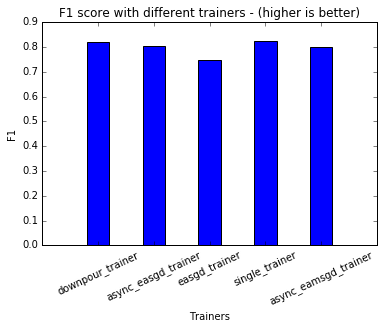

In [36]:
# Plot the F1 score of the trainers.
plt.bar(range(len(results)), results.values(), 0.4, align='center', color='b')
plt.xticks(range(len(results)), results.keys(), rotation=25)
plt.xlabel('Trainers')
plt.ylabel('F1')
plt.title("F1 score with different trainers - (higher is better)")
plt.show()

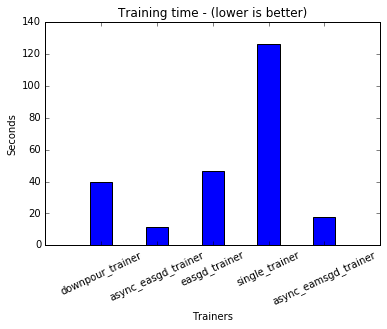

In [37]:
# Plot the training time of the trainers.
plt.bar(range(len(time_spent)), time_spent.values(), 0.4, align='center', color='b')
plt.xticks(range(len(time_spent)), time_spent.keys(), rotation=25)
plt.xlabel('Trainers')
plt.ylabel('Seconds')
plt.title("Training time - (lower is better)")
plt.show()

In [38]:
print("Number of parallel workers: " + `num_workers`)
improvement = (time_spent['single_trainer'] / time_spent['async_easgd_trainer']) * 100.0
print("Improvement using AEASGD: " + `improvement` + " %")

Number of parallel workers: 24
Improvement using AEASGD: 1086.996879603383 %


## Scaling

In the following section we will investigate the scaling of the algorithms, and how the scaling influences the model performance (statistical efficiency).

In [39]:
min_num_workers = 2
max_num_workers = num_workers
scaling_results = {}
scaling_time_spent = {}

In [40]:
for i in range(min_num_workers, max_num_workers):
    print("Evaluating for " + str(i) + " parallel workers.")
    async_easgd_trainer = AsynchronousEASGD(keras_model=model, features_col="features_normalized",
                                            batch_size=10, num_workers=i, rho=5.0, learning_rate=0.05,
                                            worker_optimizer=optimizer, loss=loss, communication_window=30)
    time_start = time.time()
    trained_model = async_easgd_trainer.train(trainingSet)
    dt = time.time() - time_start
    print("- Training done. Training time: " + str(dt))
    score = evaluate(trained_model)
    print("F1 score: " + str(score))
    scaling_results[i] = score
    scaling_time_spent[i] = dt

Evaluating for 2 parallel workers.
- Training done. Training time: 67.6668539047
F1 score: 0.823824620987
Evaluating for 3 parallel workers.
- Training done. Training time: 46.3457570076
F1 score: 0.8207360885
Evaluating for 4 parallel workers.
- Training done. Training time: 36.1570119858
F1 score: 0.817471544839
Evaluating for 5 parallel workers.
- Training done. Training time: 29.4815750122
F1 score: 0.821253776313
Evaluating for 6 parallel workers.
- Training done. Training time: 26.029020071
F1 score: 0.815843987941
Evaluating for 7 parallel workers.
- Training done. Training time: 26.2651281357
F1 score: 0.819971340571
Evaluating for 8 parallel workers.
- Training done. Training time: 21.4539899826
F1 score: 0.814552044098
Evaluating for 9 parallel workers.
- Training done. Training time: 21.5333340168
F1 score: 0.815278651449
Evaluating for 10 parallel workers.
- Training done. Training time: 20.7188639641
F1 score: 0.810969336874
Evaluating for 11 parallel workers.
- Training d

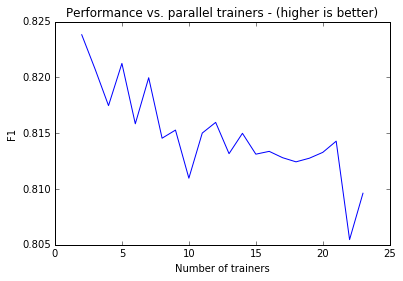

In [41]:
# Plot the F1 score of the different number of trainers.
x = scaling_results.keys()
y = scaling_results.values()
plt.plot(x, y)
plt.xlabel('Number of trainers')
plt.ylabel('F1')
plt.title("Performance vs. parallel trainers - (higher is better)")
plt.show()

In the plot below, the **green line** depicts the expected decrease in training time when using $n$ amount of parallel trainers.

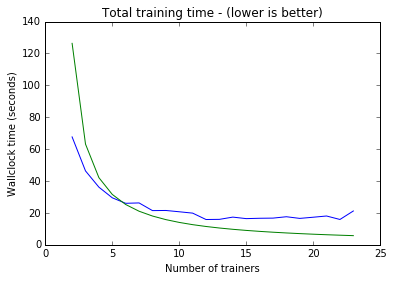

In [62]:
# Plot the training time of the different number of trainers.
x_1 = scaling_time_spent.keys()
x_2 = np.arange(0, max_num_workers, 1)
y_1 = scaling_time_spent.values()
y_2 = np.zeros(max_num_workers)
y_2.fill(time_spent['single_trainer'])
for i in range(0, max_num_workers - 1):
    y_2[i] /= i
x_2 = list(x_2)
y_2 = list(y_2)
plt.plot(x_1, y_1)
plt.plot(x_2, y_2)
plt.xlabel('Number of trainers')
plt.ylabel('Wallclock time (seconds)')
plt.title("Total training time - (lower is better)")
plt.show()

### Asynchrony induces momentum (research, not finished)

**Note:** The following section is subject to research. EASGD derived methods not similar to DOWNPOUR methods, and thus behave different. Furthermore, the theoretical influence of a *communication window* is not very well understood either.

As we mentioned in the introduction, for asynchronous methods scaling induces momentum. Meaning, adding more parallel workers adds momentum. This is formalized in the Equation below where $n$ is the number of workers being used, more details are described in [[2]](https://arxiv.org/pdf/1606.04487v4.pdf).

$$\mathbb{E}V_{t+1} = \Bigg(1 - \frac{1}{n}\Bigg)\mathbb{E}V_t - \frac{\eta}{n}\mathbb{E}\nabla f(x)$$

Using the right value can significantly reduce the number of iterations to reach the desired target loss. As seen from the plots the statistical performance of asynchronous EASGD reduces significantly. Note that this implementation does not have any explicit momentum term. This means that the algorithm is equivalent to EAMSGD, but with momentum 0. In order to confirm this statement, can we tune momentum in such a way (given the theory) that we will achieve a good model performance while using more parallel workers, and thus reducing training time.

First, we will run EAMSGD with momentum 0.0 in order to demonstrate the equivalence with asynchronous EASGD. Note that both will have implicit momentum due to the asynchronous method.

In [43]:
# This is the implicit momentum induced by the asynchronous method.
implicit_momentum = (1 - 1.0 / num_workers)

print("Implicit momentum: " + str(implicit_momentum))

Implicit momentum: 0.958333333333


In [44]:
async_easgd_trainer = AsynchronousEASGD(keras_model=model, features_col="features_normalized",
                                        batch_size=10, num_workers=num_workers, rho=5.0, learning_rate=0.05,
                                        worker_optimizer=optimizer, loss=loss, communication_window=30)
trained_model = async_easgd_trainer.train(trainingSet)
score = evaluate(trained_model)

print("F1 (Asynchronous EASGD) with implicit momentum: " + str(score))

F1 (Asynchronous EASGD) with implicit momentum: 0.805298116693


In [45]:
async_eamsgd_trainer = AsynchronousEAMSGD(keras_model=model, features_col="features_normalized",
                                          batch_size=10, num_workers=num_workers, rho=5.0, learning_rate=0.05,
                                          worker_optimizer=optimizer, loss=loss, communication_window=30,
                                          momentum=0.0)
trained_model = async_eamsgd_trainer.train(trainingSet)
score = evaluate(trained_model)

print("F1 (EAMSGD with expl. momentum 0.0 and impl. momentum): " + str(score))

F1 (EAMSGD with expl. momentum 0.0 and impl. momentum): 0.727015066033


Next, we tune the momentum turn in such a way (according to the theory) we will achieve the same statistical performance with a smaller of number of parallel workers.

In [46]:
# We estimated (guessing) the optimal momentum of the dataset.
optimal_momentum = 0.98

In [47]:
corrected_momentum = (optimal_momentum - implicit_momentum)

**Note:** Our *explicit* momentum is ***negative*** in order to compensate for the implicit momentum induced by the asynchronous method.

In [48]:
async_eamsgd_trainer = AsynchronousEAMSGD(keras_model=model, features_col="features_normalized",
                                          batch_size=10, num_workers=num_workers, rho=5.0, learning_rate=0.05,
                                          worker_optimizer=optimizer, loss=loss, communication_window=30,
                                          momentum=corrected_momentum)
trained_model = async_eamsgd_trainer.train(trainingSet)
score = evaluate(trained_model)

print("F1 (Asynchronous EAMSGD with momentum 0.0): " + `score`)

F1 (Asynchronous EAMSGD with momentum 0.0): 0.7224291134896238


**Personal note**: It seems that a large communication window reduces the implicit momentum. However, this has to be examined further.

## Experimental observations

- DOWNPOUR converges well when a small communication window is used $< 5$.
- EASGD based methods on the other hand, thrive using large communication windows $> 25$.
- Asynchronous methods induce implicit momentum.
- Smaller ($< 64$) mini-batch sizes improve EASGD performance, but for the synchronous case this increases synchronization time.

## Summary

Distributed Deep Learning can **significantly speedup** the learning process. We provide such a framework built on top of Keras and Apache Spark. The latter provides a nice framework for distributed data processing and model evaluation. We can easily integrate our workflows using Apache Spark, and thus speeding up the **data preprocessing**, and our **model optimization procedure** while still having the same **modelling simplicity**.

Our group is always open on further collaboration on this work, and would like to assist the physics community in their machine learning efforts.

**Contact**: [it-dep-db-sas@cern.ch](mailto:it-dep-db-sas@cern.ch)

## Future work

- Understanding "theoretical" meaning of a communication window.
- Apply compression for big weight updates when sending updates to the parameter server.
- Keep track of a gradient residual (this will reduce the bandwidth due to sparsity).
- Evaluation of algorithms with GPU's.
- Optimization of parameter sharing (e.g., sockets instead of REST API).
- Use "famous" ConvNet architectures with well known datasets in order to have a more sound evaluation.
- Add threaded queue to process asynchronous updates.
- Training accuracy while training.
- Stop on target loss.

## Acknowledgments

Many thanks to Zbigniew Baranowski and Luca Canali of the IT-DB group, and to Jean-Roch Vlimant, Maurizio Pierini, and Federico Presutti of the EP-UCM group for their collaboration on this work.